In [26]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import tifffile as sktif
import torch, catalyst
from catalyst.dl import SupervisedRunner
from catalyst.contrib.optimizers import RAdam, Lookahead
from catalyst.contrib.criterion import DiceLoss, IoULoss

from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, CriterionAggregatorCallback
from catalyst import utils
import numpy as np
import cv2
from functools import partial

from joblib import Parallel, delayed
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import functools, traceback
import glob


from pathlib import Path
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
from albumentations.pytorch import ToTensor, ToTensorV2
import collections
import random
%matplotlib inline

is_fp16_used = True
torch.__version__, catalyst.__version__

('1.3.1', '19.11.3')

In [2]:
from catalyst.utils import get_available_gpus

get_available_gpus()

[0]

In [5]:
from typing import List, Tuple, Callable
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
def filter_files(files, include=[], exclude=[]):
    for incl in include:
        files = [f for f in files if incl in f.name]
    for excl in exclude:
        files = [f for f in files if excl not in f.name]
    return sorted(files)

def ls(x, recursive=False, include=[], exclude=[]):
    if not recursive:
        out = list(x.iterdir())
    else:
        out = [o for o in x.glob('**/*')]
    out = filter_files(out, include=include, exclude=exclude)
    return out

Path.ls = ls

In [7]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

train_images_crops = data_dir/"train_crops"
# train_mask_crops = data_dir/"mask_crops"
train_mask_crops = data_dir/"mask_crops_single_channel"

In [8]:
train_images_crops.ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_guatemala-volcano_00000000_pre_disaster._0.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_guatemala-volcano_00000000_pre_disaster._1.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_guatemala-volcano_00000000_pre_disaster._3.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_guatemala-volcano_00000000_pre_disaster._4.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_guatemala-volcano_00000000_pre_disaster._6.png')]

In [9]:
unique_img_ids = list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() ]))
np.random.seed(42)
np.random.shuffle(unique_img_ids)
train_ids = unique_img_ids[:int(0.8 * len(unique_img_ids))]
valid_ids = unique_img_ids[int(0.8 * len(unique_img_ids)):]

In [10]:
def is_valid_func(fname):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(masks[index]))

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

In [11]:
all_images = train_images_crops.ls()
all_masks = [train_mask_crops/x.name.replace('rgb', 'mask') for x in all_images]

all_masks[:2]

[PosixPath('/media/wwymak/Storage/xView2/mask_crops_single_channel/mask_guatemala-volcano_00000000_pre_disaster._0.png'),
 PosixPath('/media/wwymak/Storage/xView2/mask_crops_single_channel/mask_guatemala-volcano_00000000_pre_disaster._1.png')]

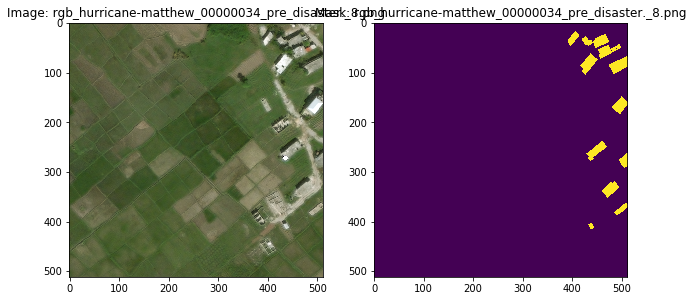

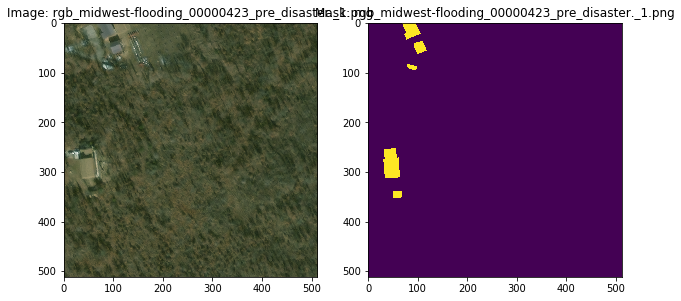

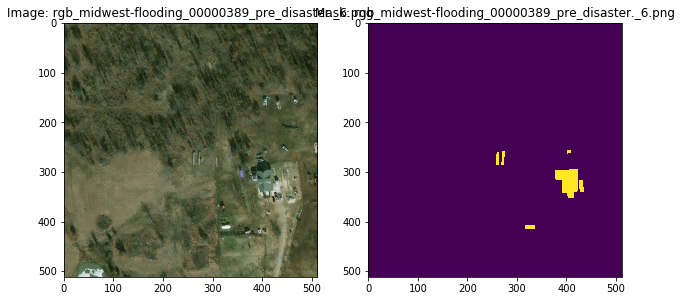

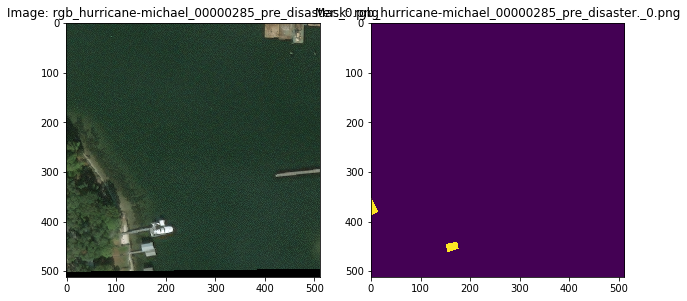

In [21]:
for i in range(4):
    show_random(all_images, all_masks)

In [23]:
class SegmentationDataset(Dataset):
    def __init__(self, images:List[Path], masks:List[Path], transforms=None):
        self.images = images
        self.masks = masks
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]
        
        image = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))
        
        result = {"image": image, "mask": mask}
        if self.transforms is not None:
            result = self.transforms(**result)
    
        return result

In [31]:
def pre_transforms(image_size=256, interpolation=cv2.INTER_LINEAR):
    return [albu.Resize(image_size, image_size, interpolation=interpolation, p=1)]
def resize_transforms(image_size=256):
    pre_size = int(image_size * 1.5)
    
    random_crop = albu.Compose([
        albu.SmallestMaxSize(pre_size, p=1),
        albu.RandomCrop(image_size, image_size, p=1)
    ])
    
    rescale = albu.Compose([
        albu.Resize(image_size, image_size, p=1)
    ])
    
    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(image_size, image_size, p=1)
    ])

    # Converts the image to a square of size image_size x image_size
    result = [
     albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result

def post_transforms():
    return [albu.Normalize(), ToTensor()]

def image_transforms():
    result = [
        albu.RandomRotate90(),
        albu.Cutout(),
        albu.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
        ),
        albu.GridDistortion(p=0.3),
        albu.HueSaturationValue(p=0.3)
    ]
    return result

def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result


In [32]:
train_transforms = compose([resize_transforms(), image_transforms(), post_transforms()])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([resize_transforms(), image_transforms()])

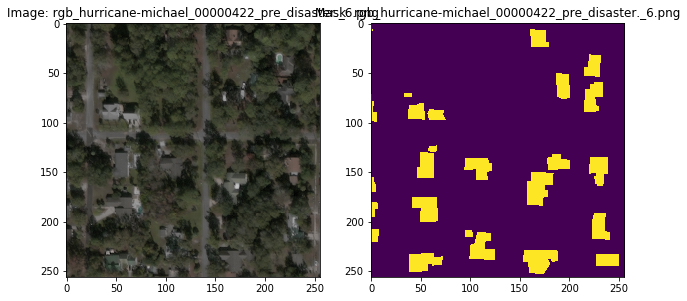

In [34]:
show_random(all_images, all_masks, transforms=show_transforms)

In [35]:
def get_loaders(image_files_train:List[Path], mask_files_train:List[Path],
                image_files_valid:List[Path], mask_files_valid:List[Path],
                random_state:int,
                batch_size:int=32,
                num_workers:int=0,
                train_transforms=None,
                valid_transforms=None
               )-> dict:
    
    train_dataset = SegmentationDataset(
        images=image_files_train,
        masks=mask_files_train,
        transforms=train_transforms
    )
    
    valid_dataset = SegmentationDataset(
        images=image_files_valid,
        masks=mask_files_valid,
        transforms=valid_transforms
    )
    
    train_dataload = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=num_workers)
    
    valid_dataload = DataLoader(valid_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=num_workers)
    
    
    loaders = collections.OrderedDict()
    loaders["train"] = train_dataload
    loaders["valid"] = valid_dataload

    return loaders

In [36]:
image_files_train = [x for x in all_images if not is_valid_func(x)]
image_files_valid= [x for x in all_images if is_valid_func(x)]

mask_files_train= [train_mask_crops/x.name.replace('rgb', 'mask') for x in image_files_train]
mask_files_valid = [train_mask_crops/x.name.replace('rgb', 'mask') for x in image_files_valid]

In [37]:
batch_size=8
SEED=42
loaders = get_loaders(
    image_files_train, mask_files_train,
    image_files_valid, mask_files_valid,
    random_state=SEED,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    batch_size=batch_size
)

In [39]:
from catalyst.contrib.models import ResnetFPNUnet
from catalyst.contrib.optimizers import RAdam, Lookahead

model = ResnetFPNUnet(num_classes=1, arch="resnet34", pretrained=True)
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": torch.nn.BCEWithLogitsLoss()
}




learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)
from catalyst.dl import SupervisedRunner

num_epochs = 1
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets", in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda
FP16 params: {'opt_level': 'O1'}


In [40]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    
    # our dataloaders
    loaders=loaders,
    
    callbacks=[
        # Each criterion is calculated separately.
        CriterionCallback(
            input_key="mask",
            prefix="loss_dice",
            criterion_key="dice"
        ),
        CriterionCallback(
            input_key="mask",
            prefix="loss_iou",
            criterion_key="iou"
        ),
        CriterionCallback(
            input_key="mask",
            prefix="loss_bce",
            criterion_key="bce",
            multiplier=0.8
        ),
        
        # And only then we aggregate everything into one loss.
        CriterionAggregatorCallback(
            prefix="loss",
#             loss_keys=["loss_bce"],
            loss_keys=["loss_dice", "loss_iou", "loss_bce"],
            loss_aggregate_fn="sum" # or "mean"
        ),
        
        # metrics
        DiceCallback(input_key="mask"),
        IouCallback(input_key="mask"),
    ],
    # path to save logs
    logdir=logdir,
    
    num_epochs=num_epochs,
    
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    
    # prints train logs
    verbose=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
1/1 * Epoch (train):   3% 54/1576 [00:21<09:38,  2.63it/s, dice=0.404, iou=0.253, loss=1.566, loss_bce=0.223, loss_dice=0.596, loss_iou=0.747]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
1/1 * Epoch (train): 100% 1576/1576 [11:16<00:00,  2.33it/s, dice=0.794, iou=0.659, loss=0.

In [22]:
DiceLoss??

In [31]:
from catalyst.dl.utils import criterion
criterion.dice??

In [30]:
import PIL
PIL.Image.fromarray??

In [36]:
ToTensorV2??

In [38]:
torch.from_numpy(np.array(Image.open(mask_files_train[0]))[None, ...]).shape

torch.Size([1, 512, 512])

In [35]:
from skimage.io import imread as skimread
skimread(mask_files_train[0]).shape

(512, 512)